In [ ]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [ ]:
conn = sqlite3.connect('stock_dataset.db')
cursor = conn.cursor()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/APS360/hackathon_sample_v2.csv')
nasdaq_data = pd.read_csv('/content/drive/MyDrive/APS360/nasdaq-listed.csv')
nyse_data = pd.read_csv('/content/drive/MyDrive/APS360/nyse-listed.csv')
other_data = pd.read_csv('/content/drive/MyDrive/APS360/other-listed.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.to_sql('hackathon_sample_v2', conn, if_exists='replace', index=False)
nasdaq_data.to_sql('nasdaq_listed', conn, if_exists='replace', index=False)
nyse_data.to_sql('nyse_listed', conn, if_exists='replace', index=False)
other_data.to_sql('other_listed', conn, if_exists='replace', index=False)


6409

In [ ]:
df.to_sql('hackathon_sample_v2', conn, if_exists='replace', index=False)

nasdaq_data = pd.read_csv('/content/drive/MyDrive/APS360/nasdaq-listed.csv')
nasdaq_data.to_sql('nasdaq_listed', conn, if_exists='replace', index=False)

nyse_data = pd.read_csv('/content/drive/MyDrive/APS360/nyse-listed.csv')
nyse_data.to_sql('nyse_listed', conn, if_exists='replace', index=False)

other_data = pd.read_csv('/content/drive/MyDrive/APS360/other-listed.csv')
other_data.to_sql('other_listed', conn, if_exists='replace', index=False)
cursor.execute('ALTER TABLE nasdaq_listed RENAME COLUMN Symbol TO "ACT Symbol";')


removed_outdated_tickers = pd.read_sql_query('SELECT * FROM hackathon_sample_v2 WHERE stock_ticker IN (SELECT "ACT Symbol" FROM nasdaq_listed UNION SELECT "ACT Symbol" FROM nyse_listed UNION SELECT "ACT Symbol" FROM other_listed)', conn)
removed_outdated_tickers.to_sql('tickerremoved_hackathon_sample_v2', conn, if_exists='replace', index=False)

# all companies having complete 12 months data from 2019 to 2023 atleast
atleast_five_year_companies = pd.read_sql_query("SELECT DISTINCT stock_ticker FROM tickerremoved_hackathon_sample_v2 WHERE year IN (2019, 2020, 2021, 2022, 2023) GROUP BY stock_ticker HAVING COUNT(*) = 60;",conn)

atleast_five_year_companies.to_sql('atleast_five_year_companies', conn, if_exists='replace', index=False)
filtered_df = pd.read_sql_query("Select year, month, intrinsic_value,stock_exret, stock_ticker,comp_name,be_me,ni_me,fcf_me,betadown_252d, ni_ar1, z_score, ebit_sale, at_turnover, market_equity from tickerremoved_hackathon_sample_v2 where stock_ticker IN (SELECT stock_ticker FROM atleast_five_year_companies) order by stock_ticker, year, month ", conn)

filtered_df['prev_intrinsic_value'] = filtered_df['intrinsic_value'].shift(1)
filtered_df['next_intrinsic_value'] = filtered_df['intrinsic_value'].shift(-1)


filtered_df['prev_stock_exret'] = filtered_df['stock_exret'].shift(1)
filtered_df['next_stock_exret'] = filtered_df['stock_exret'].shift(-1)


filtered_df['prev_be_me'] = filtered_df['be_me'].shift(1)
filtered_df['next_be_me'] = filtered_df['be_me'].shift(-1)


filtered_df['prev_ni_me'] = filtered_df['ni_me'].shift(1)
filtered_df['next_ni_me'] = filtered_df['ni_me'].shift(-1)


filtered_df['prev_fcf_me'] = filtered_df['fcf_me'].shift(1)
filtered_df['next_fcf_me'] = filtered_df['fcf_me'].shift(-1)

filtered_df['prev_betadown_252d'] = filtered_df['betadown_252d'].shift(1)
filtered_df['next_betadown_252d'] = filtered_df['betadown_252d'].shift(-1)

filtered_df['prev_ni_ar1'] = filtered_df['ni_ar1'].shift(1)
filtered_df['next_ni_ar1'] = filtered_df['ni_ar1'].shift(-1)

filtered_df['prev_z_score'] = filtered_df['z_score'].shift(1)
filtered_df['next_z_score'] = filtered_df['z_score'].shift(-1)

filtered_df['prev_ebit_sale'] = filtered_df['ebit_sale'].shift(1)
filtered_df['next_ebit_sale'] = filtered_df['ebit_sale'].shift(-1)

filtered_df['prev_at_turnover'] = filtered_df['at_turnover'].shift(1)
filtered_df['next_at_turnover'] = filtered_df['at_turnover'].shift(-1)

filtered_df['prev_market_equity'] = filtered_df['market_equity'].shift(1)
filtered_df['next_market_equity'] = filtered_df['market_equity'].shift(-1)

filtered_df['market_equity'] = filtered_df.apply(
    lambda row: (row['prev_market_equity'] + row['next_market_equity']) / 2 if pd.isnull(row['market_equity']) and pd.notnull(row['prev_market_equity']) and pd.notnull(row['next_market_equity'])
                else row['market_equity'],
    axis=1
)

filtered_df['intrinsic_value'] = filtered_df.apply(
    lambda row: (row['prev_intrinsic_value'] + row['next_intrinsic_value']) / 2 if pd.isnull(row['intrinsic_value']) and pd.notnull(row['prev_intrinsic_value']) and pd.notnull(row['next_intrinsic_value'])
                else row['intrinsic_value'],
    axis=1
)

filtered_df['stock_exret'] = filtered_df.apply(
    lambda row: (row['prev_stock_exret'] + row['next_stock_exret']) / 2 if pd.isnull(row['stock_exret']) and pd.notnull(row['prev_stock_exret']) and pd.notnull(row['next_stock_exret'])
                else row['stock_exret'],
    axis=1
)

filtered_df['be_me'] = filtered_df.apply(
    lambda row: (row['prev_be_me'] + row['next_be_me']) / 2 if pd.isnull(row['be_me']) and pd.notnull(row['prev_be_me']) and pd.notnull(row['next_be_me'])
                else row['be_me'],
    axis=1
)

filtered_df['ni_me'] = filtered_df.apply(
    lambda row: (row['prev_ni_me'] + row['next_ni_me']) / 2 if pd.isnull(row['ni_me']) and pd.notnull(row['prev_ni_me']) and pd.notnull(row['next_ni_me'])
                else row['ni_me'],
    axis=1
)

filtered_df['fcf_me'] = filtered_df.apply(
    lambda row: (row['prev_fcf_me'] + row['next_fcf_me']) / 2 if pd.isnull(row['fcf_me']) and pd.notnull(row['prev_fcf_me']) and pd.notnull(row['next_fcf_me'])
                else row['fcf_me'],
    axis=1
)

filtered_df['betadown_252d'] = filtered_df.apply(
    lambda row: (row['prev_betadown_252d'] + row['next_betadown_252d']) / 2 if pd.isnull(row['betadown_252d']) and pd.notnull(row['prev_betadown_252d']) and pd.notnull(row['next_betadown_252d'])
                else row['betadown_252d'],
    axis=1
)

filtered_df['ni_ar1'] = filtered_df.apply(
    lambda row: (row['prev_ni_ar1'] + row['next_ni_ar1']) / 2 if pd.isnull(row['ni_ar1']) and pd.notnull(row['prev_ni_ar1']) and pd.notnull(row['next_ni_ar1'])
                else row['ni_ar1'],
    axis=1
)

filtered_df['z_score'] = filtered_df.apply(
    lambda row: (row['prev_z_score'] + row['next_z_score']) / 2 if pd.isnull(row['z_score']) and pd.notnull(row['prev_z_score']) and pd.notnull(row['next_z_score'])
                else row['z_score'],
    axis=1
)

filtered_df['ebit_sale'] = filtered_df.apply(
    lambda row: (row['prev_ebit_sale'] + row['next_ebit_sale']) / 2 if pd.isnull(row['ebit_sale']) and pd.notnull(row['prev_ebit_sale']) and pd.notnull(row['next_ebit_sale'])
                else row['ebit_sale'],
    axis=1
)

filtered_df['at_turnover'] = filtered_df.apply(
    lambda row: (row['prev_at_turnover'] + row['next_at_turnover']) / 2 if pd.isnull(row['at_turnover']) and pd.notnull(row['prev_at_turnover']) and pd.notnull(row['next_at_turnover'])
                else row['at_turnover'],
    axis=1
)

filtered_df['market_equity'] = filtered_df.apply(
    lambda row: (row['prev_market_equity'] + row['next_market_equity']) / 2 if pd.isnull(row['market_equity']) and pd.notnull(row['prev_market_equity']) and pd.notnull(row['next_market_equity'])
                else row['market_equity'],
    axis=1
)




# if feature is still null drop that row
filtered_df = filtered_df.dropna(subset=['intrinsic_value', 'market_equity', 'at_turnover', 'ebit_sale', 'z_score', 'ni_ar1', 'betadown_252d', 'fcf_me', 'ni_me', 'be_me', 'stock_exret'])



filtered_df['roic'] = filtered_df['ebit_sale'] * filtered_df['at_turnover']

filtered_df['bvps'] = filtered_df['be_me']*filtered_df['market_equity']



filtered_df['prev_bvps'] = filtered_df.groupby('stock_ticker')['bvps'].shift(1)
filtered_df['next_bvps'] = filtered_df.groupby('stock_ticker')['bvps'].shift(-1)


filtered_df['bvps_change'] = (filtered_df['bvps'] - filtered_df['prev_bvps']) / filtered_df['prev_bvps']

# Calculate the at_turnover change for sales growth change from the previous month
filtered_df['prev_at_turnover'] = filtered_df.groupby('stock_ticker')['at_turnover'].shift(1)
filtered_df['at_turnover_change'] = (filtered_df['at_turnover'] - filtered_df['prev_at_turnover']) / filtered_df['prev_at_turnover']

# Calculate the earnings to price  growth change from the previous month
filtered_df['prev_ni_me'] = filtered_df.groupby('stock_ticker')['ni_me'].shift(1)
filtered_df['ni_me_change'] = (filtered_df['ni_me'] - filtered_df['prev_ni_me']) / filtered_df['prev_ni_me']

# Calculate the FCF to price  growth change from the previous month
filtered_df['prev_fcf_me'] = filtered_df.groupby('stock_ticker')['fcf_me'].shift(1)
filtered_df['fcf_me_change'] = (filtered_df['fcf_me'] - filtered_df['prev_fcf_me']) / filtered_df['prev_fcf_me']

filtered_df.to_sql('filtered_hackathon_sample_v2', conn, if_exists='replace', index=False)





conn.commit()
conn.close()

<ipython-input-21-90a288529335>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['roic'] = filtered_df['ebit_sale'] * filtered_df['at_turnover']
<ipython-input-21-90a288529335>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['bvps'] = filtered_df['be_me']*filtered_df['market_equity']
<ipython-input-21-90a288529335>:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [ ]:
save_path = "/content/drive/MyDrive/APS360/filtered_hackathon_sample_v2.csv"
filtered_df.to_csv(save_path, index=False)

File saved to: /content/drive/MyDrive/APS360/filtered_hackathon_sample_v2.csv


MAE: 0.0522
MSE: 0.0055
R² Score: 0.3347


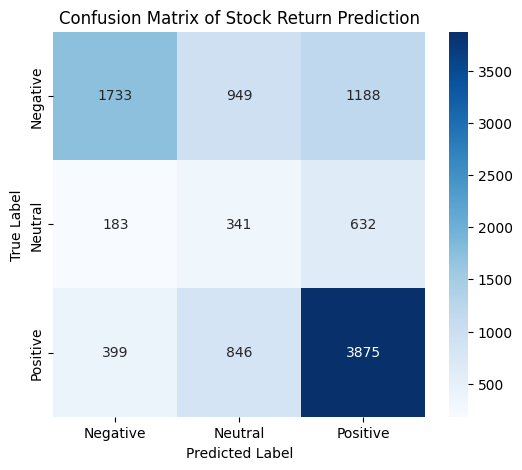

In [50]:
df = pd.read_csv("/content/drive/MyDrive/APS360/filtered_hackathon_sample_v2.csv")
features = [
   "year", "month", "intrinsic_value", "prev_stock_exret", "be_me", "ni_me", "fcf_me",
    "betadown_252d", "ni_ar1", "z_score", "ebit_sale", "at_turnover", "market_equity",
    "roic", "bvps", "prev_bvps", "bvps_change", "prev_at_turnover"]
target = "stock_exret"

df = df.dropna(subset=features + [target])

STOCK_TICKER_COLUMN = "stock_ticker"
df = df[[STOCK_TICKER_COLUMN] + features + [target]].copy()

train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.4, random_state=42)

imputer = SimpleImputer(strategy="mean")
train_df[features] = imputer.fit_transform(train_df[features])
val_df[features] = imputer.transform(val_df[features])
test_df[features] = imputer.transform(test_df[features])

# X = df[features]#input
# y = df[target]#output

scaler = StandardScaler()
X_train  = scaler.fit_transform(train_df[features])
X_val = scaler.transform(val_df[features])
X_test = scaler.transform(test_df[features])
y_train = train_df[target]
y_val = val_df[target]
y_test = test_df[target]
# X_train = train_df[features]
# X_test = test_df[features]

#initializing
rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
#training
rf.fit(X_train, y_train)
#values tending to infinte
#X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
#NaN -> median
#X_test = X_test.fillna(X_train.median())

#values tending to infinte
X_test = pd.DataFrame(X_test).replace([np.inf, -np.inf], np.nan).values # Convert X_test to DataFrame for replace, then back to NumPy array
#NaN -> median
X_test = np.nan_to_num(X_test, nan=np.nanmedian(X_train)) # Use nan_to_num with median of X_train
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Cisco January 2023
#stock_ticker = "CSCO"
#X_january = january_data[features]
#y_january_actual = january_data[target]

#y_january_pred = rf.predict(X_january)
# january_data["predicted_stock_exret"] = y_january_pred
#january_data.loc[:, "predicted_stock_exret"] = y_january_pred
#actual vs predicted
#print("\nActual vs Predicted Data for January 2023:")
#print(january_data[["year", "month"] + features + [target, "predicted_stock_exret"]])
#print(january_data[["year", "month", STOCK_TICKER_COLUMN] + features + [target, "predicted_stock_exret"]])
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define bins for actual and predicted values
def categorize_returns(y):
    return np.where(y < -0.01, "Negative",
           np.where(y > 0.01, "Positive", "Neutral"))

# Convert actual and predicted values into categories
y_test_cat = categorize_returns(y_test)
y_pred_cat = categorize_returns(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_test_cat, y_pred_cat, labels=["Negative", "Neutral", "Positive"])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Stock Return Prediction")
plt.show()

